In [45]:
#!pip install emoji transformers
#!pip install tensorflow
#!pip install sentencepiece

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk
from tqdm.notebook import tqdm
import emoji
import transformers
from tokenizers import BertWordPieceTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt') 
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


AUTO = tf.data.experimental.AUTOTUNE


def emoji_cleaning(text):
    
  # Change emoji to text
  text = emoji.demojize(text).replace(":", " ")
  
  # Delete repeated emoji
  tokenizer = text.split()
  repeated_list = []
  
  for word in tokenizer:
      if word not in repeated_list:
          repeated_list.append(word)
  
  text = ' '.join(text for text in repeated_list)
  text = text.replace("_", " ").replace("-", " ")
  return text

def clean_smileys(text):
    
    text = re.sub(r'(:\)|: \)|\(\:|:-\)|: -\)|: - \)|:D|: D)', ' smile ', text)
    text = re.sub(r'(:\(|: \(|\)\:|:-\(|: -\(|: - \(|:\'\()', ' dislike ', text)
    text = re.sub(r'(<3)', ' heart ', text)
    text = re.sub(r'(:/)', ' dislike ', text)
    text = re.sub(r'(;\)|; \))', ' wink ', text)
    return ' '.join([word for word in text.split()])

def clean_urls(review):
    review = review.split()
    review = ' '.join([word for word in review if not re.match('^http', word)])
    return review

def decontracted(text):
    text = re.sub(r"won\’t", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"can\’t", "can not", text)
    text = re.sub(r"n\’t", " not", text)
    text = re.sub(r"\’re", " are", text)
    text = re.sub(r"it\'s", "it is", text)
    text = re.sub(r"\’d", " would", text)
    text = re.sub(r"\’ll", " will", text)
    text = re.sub(r"\’t", " not", text)
    text = re.sub(r"\’ve", " have", text)
    text = re.sub(r"\’m", " am", text)

    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\’re", " are", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\’d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\’ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\’t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\’ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\’m", " am", text)
    text = re.sub(r"\“", "", text)
    text = re.sub(r"\”", "", text)
    text = re.sub(r"\…", "", text)

    return text

def clean_text(text):
    text = str(text)
    text = re.sub(r'(\w)\1{2,}', r'\1', text)
    text = re.sub(r'[^a-zA-Z ]+', ' ', text)
    text = re.sub(r'http\S+', ' ', text)
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    text = re.sub(r'^RT[\s]+', '', text)
    text = re.sub(r'pic.twitter\S+', ' ', text)
    text = re.sub(r'#', '', text)
    text = text.lower()

    return text


stop_words = stopwords.words('english') 
stop_words.remove('not') 
lemmatizer = WordNetLemmatizer()

def data_preprocessing(review):
    
  # data cleaning
    review = re.sub(re.compile('<.*?>'), '', review) #removing html tags
    review =  re.sub('[^A-Za-z0-9]+', ' ', review) #taking only words
  
  # lowercase
    review = review.lower()
  
  # tokenization
    tokens = nltk.word_tokenize(review) # converts review to tokens
  
  # stop_words removal
    review = [word for word in tokens if word not in stop_words] #removing stop words
  
  # lemmatization
    review = [lemmatizer.lemmatize(word) for word in review]
  
  # join words in preprocessed review
    review = ' '.join(review)
    return review

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Sherwin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sherwin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Sherwin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Sherwin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [46]:
df = pd.read_csv('biden_tweet_text.csv', encoding = 'utf8')
df.head()

,ID,Tweet Text,Sentiment
0,0,"yet you are uncertain why 23,000 + votes ( 98 ...",negative
1,1,little known fact – that biden ’s support f...,negative
2,2,i speak for all americans when i say joe bi...,negative
3,3,he ’s using biden ’s words . what a fraud .,negative
4,4,"i 'm sorry , i do n't see the world that ...",negative


In [47]:
df['Tweet Text'].isnull().sum()


0

In [48]:
print("Total Number of positive reviews in Tweet: ", df[df['Sentiment']== "positive"].shape[0])
print("Total Number of negative reviews in Tweet: ", df[df['Sentiment']== "negative"].shape[0])

Total Number of positive reviews in Tweet:  7924
Total Number of negative reviews in Tweet:  6078


##### Sample Positive Review


In [49]:
df[df['Sentiment']== "positive"].sample(n=1)['Tweet Text'].iloc[0]

"unpopular opinion : if biden horse trades a trump pardon for a big ticket item , like a comprehensive infrastructure and green energy initiative , i 'll take it . that will make a democratic presidency a huge success and trump will still be under state - level legal jeopardy ."

##### Sample Negative Review


In [50]:
df[df['Sentiment']== "negative"].sample(n=1)['Tweet Text'].iloc[0]

'were you wondering ?   it ’s a biden administration thing .   i know .   i know .   he legit is a ra_cist .   i ’m not saying george bush is good .   i am trying to find something that works in this insane world .'

In [51]:
word_counts = df['Tweet Text'].apply(lambda x: len(x.split()))

word_counts.describe()

count    14002.000000
mean        31.704828
std         16.810759
min          2.000000
25%         17.000000
50%         29.000000
75%         46.000000
max        101.000000
Name: Tweet Text, dtype: float64

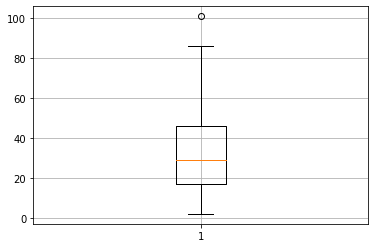

In [52]:
plt.boxplot(word_counts.values)
plt.grid(True)
plt.show()

In [53]:
df['Tweet Text'] = df['Tweet Text'].apply(clean_urls).apply(clean_text).apply(emoji_cleaning).apply(clean_smileys).apply(decontracted)
#.apply(correct_spellings)

In [54]:
df['Tweet Text'] = df['Tweet Text'].apply(lambda review: data_preprocessing(review))
df.head()


,ID,Tweet Text,Sentiment
0,0,yet uncertain vote biden logged location short...,negative
1,1,little known fact biden support thatcher not f...,negative
2,2,speak american say joe biden president trump n...,negative
3,3,using biden word fraud,negative
4,4,sorry n see world way head mask wish fear domi...,negative


In [55]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


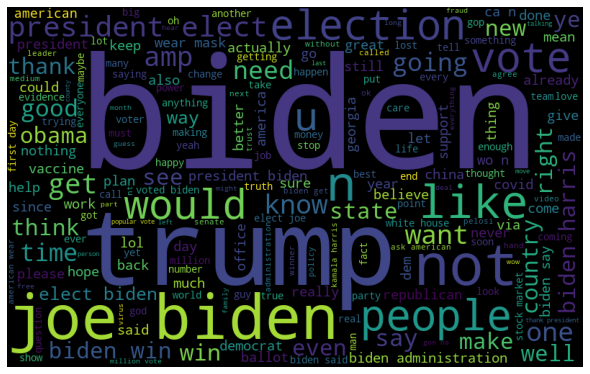

In [58]:
# Positive Tweets wordcloud

import wordcloud
from wordcloud import WordCloud

words_list = df[df['Sentiment']== "positive"]['Tweet Text'].unique().tolist()
pos_words = " ".join(words_list)

pos_wordcloud =  WordCloud(
                  width=800, height = 500,            
                  stopwords=stop_words).generate(pos_words)

plt.figure(figsize=(8, 8), facecolor = None)
plt.imshow(pos_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

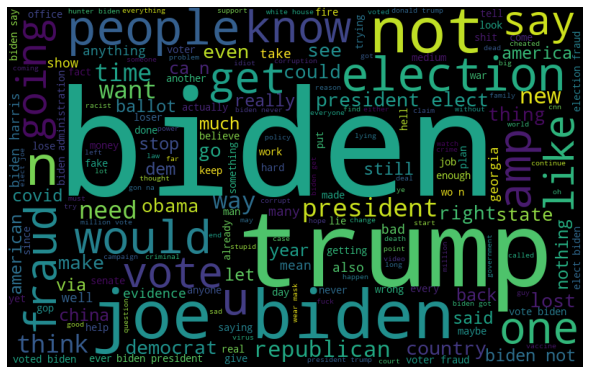

In [59]:
# Negative Tweets wordcloud

import wordcloud
from wordcloud import WordCloud

words_list = df[df['Sentiment']== "negative"]['Tweet Text'].unique().tolist()
pos_words = " ".join(words_list)

pos_wordcloud =  WordCloud(
                  width=800, height = 500,            
                  stopwords=stop_words).generate(pos_words)

plt.figure(figsize=(8, 8), facecolor = None)
plt.imshow(pos_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [60]:
df.to_csv('preprocessed_biden_tweet_text.csv', encoding='utf-8', index=False)